#Importing Libraries and dataset




In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import spacy
import string
import gensim
import operator
import re

In [3]:
df_movies = pd.read_csv('/content/movies1.csv')
df_movies.head()

,rank,title,genre,wiki_plot,imdb_plot
0,0,The Godfather,"[u' Crime', u' Drama']","On the day of his only daughter's wedding, Vit...","In late summer 1945, guests are gathered for t..."
1,1,The Shawshank Redemption,"[u' Crime', u' Drama']","In 1947, banker Andy Dufresne is convicted of ...","In 1947, Andy Dufresne (Tim Robbins), a banker..."
2,2,Schindler's List,"[u' Biography', u' Drama', u' History']","In 1939, the Germans move Polish Jews into the...",The relocation of Polish Jews from surrounding...
3,3,Raging Bull,"[u' Biography', u' Drama', u' Sport']","In a brief scene in 1964, an aging, overweight...","The film opens in 1964, where an older and fat..."
4,4,Casablanca,"[u' Drama', u' Romance', u' War']",It is early December 1941. American expatriate...,"In the early years of World War II, December 1..."


#Pre-processing the Data(text) and Tokenizing

Removing unwanted words (stop words) , punctuations , extra lines , spaces , etc that donot contribute to the topic modelling in anyway.

Tokenizing: Converting sentences to List of words

In [4]:
from spacy.lang.en.stop_words import STOP_WORDS

spacy_nlp = spacy.load('en_core_web_sm')

#create list of punctuations and stopwords
punctuations = string.punctuation
stop_words = spacy.lang.en.stop_words.STOP_WORDS

#function for data cleaning and processing
#This can be further enhanced by adding / removing reg-exps as desired.

def spacy_tokenizer(sentence):

    #remove distracting single quotes
    sentence = re.sub('\'','',sentence)

    #remove digits adnd words containing digits
    sentence = re.sub('\w*\d\w*','',sentence)

    #replace extra spaces with single space
    sentence = re.sub(' +',' ',sentence)

    #remove unwanted lines starting from special charcters
    sentence = re.sub(r'\n: \'\'.*','',sentence)
    sentence = re.sub(r'\n!.*','',sentence)
    sentence = re.sub(r'^:\'\'.*','',sentence)

    #remove non-breaking new line characters
    sentence = re.sub(r'\n',' ',sentence)

    #remove punctunations
    sentence = re.sub(r'[^\w\s]',' ',sentence)

    #creating token object
    tokens = spacy_nlp(sentence)

    #lower, strip and lemmatize
    tokens = [word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in tokens]

    #remove stopwords, and exclude words less than 2 characters
    tokens = [word for word in tokens if word not in stop_words and word not in punctuations and len(word) > 2]

    #return tokens
    return tokens

In [5]:
print ('Cleaning and Tokenizing...')
%time df_movies['wiki_plot_tokenized'] = df_movies['wiki_plot'].map(lambda x: spacy_tokenizer(x))

df_movies.head()

Cleaning and Tokenizing...
CPU times: user 36 s, sys: 1.67 s, total: 37.7 s
Wall time: 44.4 s


,rank,title,genre,wiki_plot,imdb_plot,wiki_plot_tokenized
0,0,The Godfather,"[u' Crime', u' Drama']","On the day of his only daughter's wedding, Vit...","In late summer 1945, guests are gathered for t...","[day, daughter, wedding, vito, corleone, hear,..."
1,1,The Shawshank Redemption,"[u' Crime', u' Drama']","In 1947, banker Andy Dufresne is convicted of ...","In 1947, Andy Dufresne (Tim Robbins), a banker...","[banker, andy, dufresne, convict, murder, wife..."
2,2,Schindler's List,"[u' Biography', u' Drama', u' History']","In 1939, the Germans move Polish Jews into the...",The relocation of Polish Jews from surrounding...,"[germans, polish, jews, kraków, ghetto, world,..."
3,3,Raging Bull,"[u' Biography', u' Drama', u' Sport']","In a brief scene in 1964, an aging, overweight...","The film opens in 1964, where an older and fat...","[brief, scene, age, overweight, italian, ameri..."
4,4,Casablanca,"[u' Drama', u' Romance', u' War']",It is early December 1941. American expatriate...,"In the early years of World War II, December 1...","[early, december, american, expatriate, rick, ..."


In [6]:
movie_plot = df_movies['wiki_plot_tokenized']
movie_plot[0:5]

0    [day, daughter, wedding, vito, corleone, hear,...
1    [banker, andy, dufresne, convict, murder, wife...
2    [germans, polish, jews, kraków, ghetto, world,...
3    [brief, scene, age, overweight, italian, ameri...
4    [early, december, american, expatriate, rick, ...
Name: wiki_plot_tokenized, dtype: object

#Visualisation of Data :

Word Cloud - Most repeated word is of the biggest size

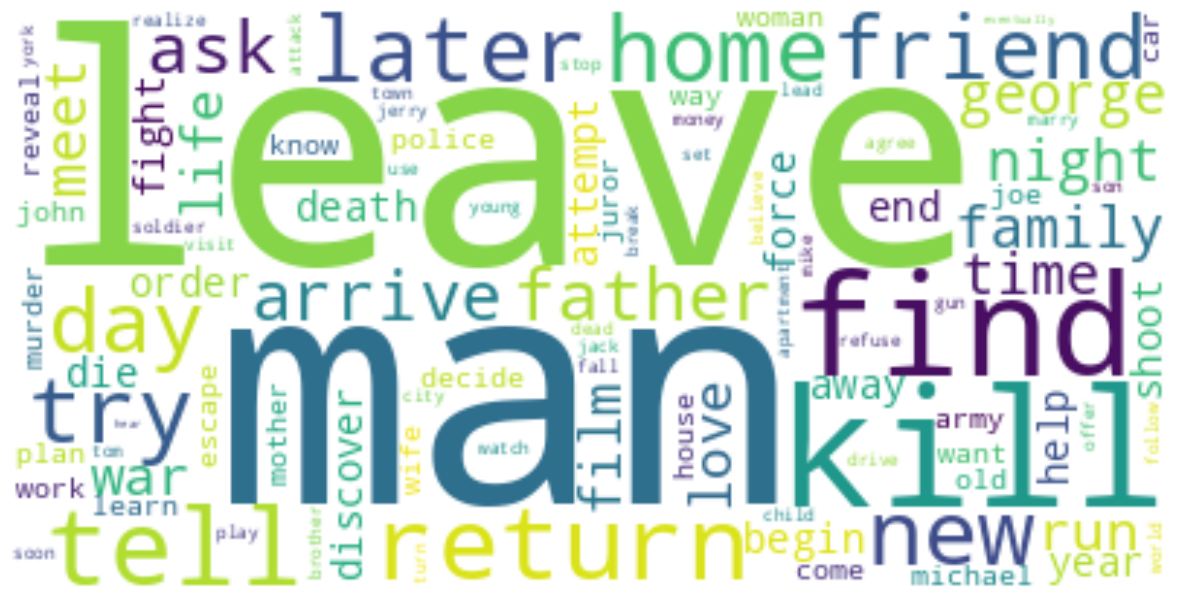

In [7]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

series = pd.Series(np.concatenate(movie_plot)).value_counts()[:100]
wordcloud = WordCloud(background_color='white').generate_from_frequencies(series)

plt.figure(figsize=(15,15), facecolor = None)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

#Building Word Dictionary :

1. We have built the vocabulary of the corpus in which all the unique words are given IDs and their frequency counts are also stored.

  We used Gensim library to build the dictionary and in gensim, the words are referred as “tokens” and the index of each word in the dictionary is called ID

2. Removed content neutral words from the dictionary and additional stop-words.

In [8]:
from gensim import corpora

#creating term dictionary
%time dictionary = corpora.Dictionary(movie_plot)

#list of few which which can be further removed
stoplist = set('hello and if this can would should could tell ask stop come go')
stop_ids = [dictionary.token2id[stopword] for stopword in stoplist if stopword in dictionary.token2id]
dictionary.filter_tokens(stop_ids)

CPU times: user 97.5 ms, sys: 0 ns, total: 97.5 ms
Wall time: 112 ms


In [9]:
#print top 50 items from the dictionary with their unique token-id
dict_tokens = [[[dictionary[key], dictionary.token2id[dictionary[key]]] for key, value in dictionary.items() if key <= 50]]
print (dict_tokens)

[[['abrasive', 0], ['abroad', 1], ['abuse', 2], ['accept', 3], ['accuse', 4], ['act', 5], ['adams', 6], ['add', 7], ['address', 8], ['agree', 9], ['ambush', 10], ['angeles', 11], ['answer', 12], ['anthony', 13], ['apollonia', 14], ['arrange', 15], ['ask', 16], ['assassin', 17], ['assassination', 18], ['associate', 19], ['attack', 20], ['attempt', 21], ['authority', 22], ['aware', 23], ['baron', 24], ['barzini', 25], ['battle', 26], ['bed', 27], ['betrayal', 28], ['bodyguard', 29], ['bomb', 30], ['booth', 31], ['brasi', 32], ['brasis', 33], ['break', 34], ['bronx', 35], ['brother', 36], ['business', 37], ['buy', 38], ['capo', 39], ['capos', 40], ['captain', 41], ['car', 42], ['career', 43], ['carlo', 44], ['casino', 45], ['christening', 46], ['christmas', 47], ['clampdown', 48], ['clemenza', 49], ['collapse', 50]]]


#Feature Extraction (Bag of Words)
A bag of words model, or BoW for short is a way of extracting features from text for use in modelling, such as with machine learning algorithms. It is a representation of text that describes the occurence of words within a document.

The doc2bow method of dictionary, iterates through all the words in the text, if the word already exists in the corpus, it increments the frequency count, other wise it inserts the word into the corpus and sets it frequency count to 1

In [10]:
corpus = [dictionary.doc2bow(desc) for desc in movie_plot]

word_frequencies = [[(dictionary[id], frequency) for id, frequency in line] for line in corpus[0:3]]

print(word_frequencies)

[[('abrasive', 2), ('abroad', 2), ('abuse', 4), ('accept', 6), ('accuse', 2), ('act', 2), ('adams', 3), ('add', 2), ('address', 2), ('agree', 2), ('ambush', 2), ('angeles', 2), ('answer', 2), ('anthony', 3), ('apollonia', 2), ('arrange', 2), ('ask', 2), ('assassin', 4), ('assassination', 4), ('associate', 2), ('attack', 4), ('attempt', 4), ('authority', 2), ('aware', 2), ('baron', 2), ('barzini', 7), ('battle', 2), ('bed', 2), ('betrayal', 2), ('bodyguard', 2), ('bomb', 2), ('booth', 2), ('brasi', 3), ('brasis', 2), ('break', 2), ('bronx', 2), ('brother', 6), ('business', 6), ('buy', 2), ('capo', 1), ('capos', 2), ('captain', 2), ('car', 2), ('career', 2), ('carlo', 7), ('casino', 2), ('christening', 4), ('christmas', 2), ('clampdown', 2), ('clemenza', 3), ('collapse', 2), ('come', 4), ('command', 2), ('confess', 2), ('confront', 2), ('connection', 2), ('connie', 4), ('connies', 2), ('consigliere', 5), ('contact', 2), ('corleone', 10), ('corleones', 4), ('corps', 3), ('coveted', 2), ('

#Model Building
###Building TFIDF and LSI Models:

Tf-Idf (Term frequency-Inverse Document Frequency): It is a commonly used NLP model that helps you determine the most important words in each document in the corpus.

Latent Semantic Analysis (aka Latent Semantic Indexing): It implements fast truncated SVD (Singular Value Decomposition) to reduce the dimension of the matrix and gives us latent themes.




In [11]:
%time movie_tfidf_model = gensim.models.TfidfModel(corpus, id2word=dictionary)
%time movie_lsi_model = gensim.models.LsiModel(movie_tfidf_model[corpus], id2word=dictionary, num_topics=300)

CPU times: user 45.4 ms, sys: 0 ns, total: 45.4 ms
Wall time: 106 ms
CPU times: user 2.43 s, sys: 1.1 s, total: 3.54 s
Wall time: 2.98 s


In [12]:
%time gensim.corpora.MmCorpus.serialize('movie_tfidf_model_mm', movie_tfidf_model[corpus])
%time gensim.corpora.MmCorpus.serialize('movie_lsi_model_mm',movie_lsi_model[movie_tfidf_model[corpus]])

CPU times: user 185 ms, sys: 19.3 ms, total: 204 ms
Wall time: 225 ms
CPU times: user 140 ms, sys: 3.86 ms, total: 144 ms
Wall time: 149 ms


In [13]:
#Load the indexed corpus
movie_tfidf_corpus = gensim.corpora.MmCorpus('movie_tfidf_model_mm')
movie_lsi_corpus = gensim.corpora.MmCorpus('movie_lsi_model_mm')

print(movie_tfidf_corpus)
print(movie_lsi_corpus)

MmCorpus(100 documents, 8400 features, 25983 non-zero entries)
MmCorpus(100 documents, 100 features, 10000 non-zero entries)


In [14]:
from gensim.similarities import MatrixSimilarity

%time movie_index = MatrixSimilarity(movie_lsi_corpus, num_features = movie_lsi_corpus.num_terms)

CPU times: user 21.4 ms, sys: 30 µs, total: 21.4 ms
Wall time: 32.1 ms


#Similarity Score , Semantic Search :
With the index of movies initialized and loaded, we can use it to find similar movies based on Latent themes

We will input a search query , apply LSI Model for it with similar steps and model will return relevant movie titles with "Relevance %" which is the similarity score. The higher the similarity score, the more similar the query to the document at the given index

Helper function is to search the index, sort and return the results

In [23]:
from operator import itemgetter

def search_similar_movies(search_term):

    query_bow = dictionary.doc2bow(spacy_tokenizer(search_term))
    query_tfidf = movie_tfidf_model[query_bow]
    query_lsi = movie_lsi_model[query_tfidf]

    movie_index.num_best = 10

    movies_list = movie_index[query_lsi]

    movies_list.sort(key=itemgetter(1), reverse=True)
    movie_names = []

    for j, movie in enumerate(movies_list):
      movie_names.append (
            {
                'Relevance': round((movie[1] * 100),2),
                'Movie Title': df_movies['title'][movie[0]],
                'Movie Plot': df_movies['wiki_plot'][movie[0]]
            }

        )

      if j == (movie_index.num_best-1):
            break

    return pd.DataFrame(movie_names, columns=['Relevance','Movie Title','Movie Plot'])

In [24]:
# search for movie tiles that are related to below search parameters
search_similar_movies('crime and drugs ')

,Relevance,Movie Title,Movie Plot
0,81.88,Goodfellas,"Henry Hill (Liotta) admits, ""As far back as I ..."
1,33.94,The French Connection,"In Marseille, an undercover detective is follo..."
2,32.09,The Godfather,"On the day of his only daughter's wedding, Vit..."
3,28.86,A Clockwork Orange,"In futuristic London, Alex DeLarge is the lead..."
4,13.16,On the Waterfront,Mob-connected union boss Johnny Friendly (Lee ...
5,8.58,The Green Mile,"In a Louisiana nursing home in 1999, Paul Edge..."
6,7.24,Platoon,"In 1967, Chris Taylor has dropped out of colle..."
7,6.44,Apocalypse Now,"In 1969, U.S. Army Captain and special operati..."
8,5.82,Taxi Driver,"Travis Bickle, an honorably discharged U.S. Ma..."
9,5.59,One Flew Over the Cuckoo's Nest,"In 1963 Oregon, Randle Patrick ""Mac"" McMurphy ..."


The model returns movie titles with "Relevance %". The top list movies are related to crimes and drugs.

In [25]:
# search for movie tiles that are related to below search parameters
search_similar_movies('violence protest march')

,Relevance,Movie Title,Movie Plot
0,74.08,Gandhi,The screenplay of Gandhi is available as a pub...
1,52.19,A Clockwork Orange,"In futuristic London, Alex DeLarge is the lead..."
2,27.03,Amadeus,The story begins in 1823 as the elderly Antoni...
3,24.64,All Quiet on the Western Front,\n\n\n\n\nThis section's plot summary may be t...
4,18.32,The Best Years of Our Lives,"After World War II, Fred Derry (Dana Andrews),..."
5,12.62,The Bridge on the River Kwai,"In World War II, British prisoners arrive at a..."
6,10.90,The Wizard of Oz,The film starts in sepia-tinted Kansas in the ...
7,8.18,The African Queen,Robert Morley and Katharine Hepburn play Samue...
8,6.72,The Deer Hunter,Act I[edit] Act I Act I [edit] [ [ edit ...
9,-0.00,Gone with the Wind,\nPart 1\n \n Part 1 Part 1 \n \n On the...


Here the top most movie title "Gandhi" is related to non-violence protests

In [26]:
# search for movie tiles that are related to below search parameters
search_similar_movies('love affair hate')

,Relevance,Movie Title,Movie Plot
0,45.70,Terms of Endearment,Aurora Greenway (Shirley MacLaine) and her dau...
1,44.78,The Graduate,"Benjamin Braddock, going on from twenty to twe..."
2,30.33,From Here to Eternity,"In 1941, bugler and career soldier Private Rob..."
3,28.83,Out of Africa,"The story begins in 1913 in Denmark, when Kare..."
4,27.63,Wuthering Heights,A traveller named Lockwood (Miles Mander) is c...
5,26.82,West Side Story,] ] \n In the West Side's Lincoln Square ne...
6,25.52,A Streetcar Named Desire,Blanche DuBois is a fading but still attractiv...
7,24.12,All Quiet on the Western Front,\n\n\n\n\nThis section's plot summary may be t...
8,21.16,Raging Bull,"In a brief scene in 1964, an aging, overweight..."
9,20.97,Citizen Kane,\n\n\n\nOrson Welles as Charles Foster Kane\n\...


###Manually entering the search query:

In [22]:
def search_similar_movies_manual():
  search_term = input("Enter your search term: ")
  results = search_similar_movies(search_term)
  return(results)

search_similar_movies_manual()


Enter your search term: horror


,Relevance,Movie Title,Movie Plot
0,75.44,Apocalypse Now,"In 1969, U.S. Army Captain and special operati..."
1,54.99,The Exorcist,Lankester Merrin is a veteran Catholic priest ...
2,35.38,Psycho,Patrick Bateman is a wealthy investment banker...
3,0.00,The Apartment,"Calvin Clifford (C. C.) ""Bud"" Baxter (Jack Lem..."
4,-0.00,The French Connection,"In Marseille, an undercover detective is follo..."


#Conclusion:

###In general usage, computing semantic relationships between textual data enables to recommend articles or products related to given query, to follow trends, to explore a specific subject in more details. In this project the basic version of semantic search was implemented. There are many ways to further enhance it using newer deep learning models.

###Use Cases of Semantic Search:

###1. Netflix Recommendation System

###2. Google Search Engine